# Regional and Local Sea Level Change   

## Setup

First, we need to import all the necessary libraries. 

In [1]:
# import necessary libraries
import numpy as np
import xarray as xr
import datetime as dt
from pathlib import Path
import pandas as pd
import os

# data retrieval libraries
import requests
from urllib.request import urlretrieve #used for downloading files
import json

# data processing libraries
from scipy.stats import linregress
from scipy.signal import detrend

# plotting libraries
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt



In [2]:
# Establish directories for saving and reading data
data_dir = Path('../data')

## Retrieve Data Sources

We are interested in getting tide gauge and alitmetry data for Palau (and its EEZ) for 1993 through 2018.
Let's first establish where the tide gauge is by looking at the tide gauge dataset.

### Retrieve the location of the Malakal, Palau tide gauge

In [3]:
url = 'https://uhslc.soest.hawaii.edu/data/meta.geojson' #<<--- THIS IS A "HIDDEN" URL? I CAN'T FIND IT BY CLICKING AROUND THE WEBSITE. 

#parse this url to get lat/lon of Malakal tide gauge
r = requests.get(url)
data = r.json()
for i in range(len(data['features'])):
    if data['features'][i]['properties']['name'] == 'Malakal':
        lat = data['features'][i]['geometry']['coordinates'][1]
        lon = data['features'][i]['geometry']['coordinates'][0]
        break

lat,lon    

(7.33, 134.463)

Next, let's establish a period of record. (Start and end time for analysis.) Here we'll go from 1993-2018 for now, so I can compare SL_magnitude_results with https://ccar.colorado.edu/altimetry/ as a sanity check.

In [4]:
# establish the time period of interest
start_date = dt.datetime(1993,1,1)
end_date = dt.datetime(2018,12,31)

# also have them as strings, for plotting
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

### Retrieve the EEZ boundary for Palau

Next we'll define the area we want to look at using the EEZ boundary. This can be obtained from XXX. For now it's in the data directory.

In [5]:
# Retrieve the EEZ for Palau
with open(data_dir / 'palauEEZ.json') as f:
    palau = json.load(f)

# extract the coordinates of the EEZ
palau_eez = np.array(palau['features'][0]['geometry']['coordinates'][0][0])

# get the min and max lat and lon of the EEZ, helpful for obtaining CMEMS data
min_lon = np.min(palau_eez[:,0])
max_lon = np.max(palau_eez[:,0])
min_lat = np.min(palau_eez[:,1])
max_lat = np.max(palau_eez[:,1])

### Retrieve altimetry data 

In [6]:
# To get this file, run get_CMEMS_data.py from the playground directory in a terminal with python >= 3.9 + copernicus_marine_client installed
fname_cmems = 'cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_adt-sla_129.62E-136.88E_1.62N-11.88N_1993-01-01-2023-04-30.nc'
ds = xr.open_dataset(data_dir / fname_cmems)

# slice the data to time 1993-01-01 to 2018-12-31
ds = ds.sel(time=slice(start_date, end_date))
ds

# Note I am downloading a product direct from CMEMS, not using the CMEMS data from Ayesha - I am unclear of the source.

<xarray.Dataset>
Dimensions:    (time: 9496, latitude: 42, longitude: 30)
Coordinates:
  * latitude   (latitude) float32 1.625 1.875 2.125 2.375 ... 11.38 11.62 11.88
  * longitude  (longitude) float32 129.6 129.9 130.1 130.4 ... 136.4 136.6 136.9
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2018-12-31
Data variables:
    adt        (time, latitude, longitude) float64 ...
    sla        (time, latitude, longitude) float64 ...
Attributes: (12/45)
    Conventions:                       CF-1.6
    Metadata_Conventions:              Unidata Dataset Discovery v1.0
    cdm_data_type:                     Grid
    comment:                           Sea Surface Height measured by Altimet...
    contact:                           servicedesk.cmems@mercator-ocean.eu
    creator_email:                     servicedesk.cmems@mercator-ocean.eu
    ...                                ...
    time_coverage_duration:            P1D
    time_coverage_end:                 1993-01-01T12:00:00Z
    time_coverage_resolution:          P1D
    time_coverage_start:               1992-12-31T12:00:00Z
    title:                             DT merged all satellites Global Ocean ...
    copernicus_marine_client_version:  0.10.0

### Retrieve Tide Gauge Data

In [7]:
# Here we are going to use the research quality data set, which is the best available data set for tide gauge data
uhslc_id = 7
fname = f'h{uhslc_id:03}b.nc' # h for hourly, d for daily, added b for research quality data for deployment B

url = "https://uhslc.soest.hawaii.edu/data/netcdf/rqds/pacific/hourly/" # Research Quality Data Set only goes thru 2018

path = os.path.join(data_dir, fname)

if not os.path.exists(path):
    urlretrieve(os.path.join(url, fname), path) 
    
rsl = xr.open_dataset(fname)
station_name = rsl['station_name'].values[0]
rsl

<xarray.Dataset>
Dimensions:               (record_id: 1, time: 434985)
Coordinates:
  * time                  (time) datetime64[ns] 1969-05-18T15:00:00 ... 2018-...
  * record_id             (record_id) int16 72
Data variables: (12/13)
    sea_level             (record_id, time) float32 ...
    lat                   (record_id) float32 ...
    lon                   (record_id) float32 ...
    station_name          (record_id) |S7 b'Malakal'
    station_country       (record_id) |S5 ...
    station_country_code  (record_id) float32 ...
    ...                    ...
    version               (record_id) |S1 ...
    gloss_id              (record_id) float32 ...
    ssc_id                (record_id) |S4 ...
    decimation_method     (record_id) int16 ...
    reference_code        (record_id) |S1 ...
    reference_offset      (record_id) int16 ...
Attributes:
    title:                  JASL/UHSLC Research Quality Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2023-04-04T01:53:36Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The Joint Archive for Sea Level (JASL) Research Q...
    processing_level:       The JASL receives hourly data from regional and n...
    acknowledgment:         The JASL/UHSLC Research Quality Data Set is suppo...

## Process the data

 Convert tide gauge data into daily record for the POR in units of meters to match the CMEMS data. Normalize the data to the 1993-2012 epoch.

In [8]:
# Extract the data for the 1993-2019 period
tide_gauge_data_POR = rsl['sea_level'].sel(time=slice(start_date, end_date))

# Convert to meters and drop any NaN values
tide_gauge_data_meters = tide_gauge_data_POR / 1000  # Convert from mm to meters
tide_gauge_data_clean = tide_gauge_data_meters.dropna(dim='time')

# Resampling the tide gauge data to daily mean before subtracting the epoch mean, to match the CMEMS data
tide_gauge_daily_avg = tide_gauge_data_clean.resample(time='1D').mean()

# Normalize the data relative to the 1993-2012 epoch (we will level it with CMEMS 93-12 epoch later)
epoch_start, epoch_end = start_date, '2011-12-31'
epoch_daily_avg = tide_gauge_daily_avg.sel(time=slice(epoch_start, epoch_end))
epoch_daily_mean = epoch_daily_avg.mean()

rsl_daily = tide_gauge_daily_avg - epoch_daily_mean

rsl_daily.attrs['units'] = 'm'

rsl_daily


<xarray.DataArray 'sea_level' (record_id: 1, time: 9496)>
array([[-0.12749314, -0.1223681 , -0.16636801, ..., -0.2099514 ,
        -0.18257642, -0.61703473]], dtype=float32)
Coordinates:
  * record_id  (record_id) int16 72
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2018-12-31
Attributes:
    units:    m

Run a quick check to see if the Ab SL from CMEMS is in fact zeroed about the 1993-2012 epoch. Curse the details.

In [9]:
# Normalize tide gauge data to CMEMS 1993-2012 epoch
epoch_daily_mean_cmems = ds['sla'].sel(time=slice(epoch_start, epoch_end)).sel(longitude=lon, latitude=lat, method='nearest').mean(dim='time')

formatted_mean = format(epoch_daily_mean_cmems.values, ".2f")
print(f' The mean for the [1993,2012] epoch of the SLA is {formatted_mean} m. Re-check source data to make sure this is correct.')


 The mean for the [1993,2012] epoch of the SLA is 0.02 m. Re-check source data to make sure this is correct.


### Clip
Clip the Altimetry Data Set to the area/grid of Interest

We will focus only on the grid cells nearest to the Malakal tide gauge.

In [10]:
sla = ds['sla'].sel(time=slice(start_date, end_date))
time_cmems = pd.to_datetime(sla['time'].values)

# Extract data for the nearest point to the tide gauge location
sla_nearest = sla.sel(longitude=lon, latitude=lat, method='nearest')

sla_nearest_lat = sla_nearest['latitude'].values
sla_nearest_lon = sla_nearest['longitude'].values

# Format lat lon strings to have decimal symbol and N/S and E/W
lat_str = f'{np.abs(sla_nearest_lat):.3f}\u00B0{"N" if sla_nearest_lat > 0 else "S"}'
lon_str = f'{np.abs(sla_nearest_lon):.3f}\u00B0{"E" if sla_nearest_lon > 0 else "W"}'

print(f'The closest altimetry grid point is {lat_str}, {lon_str}')


The closest altimetry grid point is 7.375°N, 134.375°E


In [11]:
sla_nearest

<xarray.DataArray 'sla' (time: 9496)>
[9496 values with dtype=float64]
Coordinates:
    latitude   float32 7.375
    longitude  float32 134.4
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2018-12-31
Attributes:
    ancillary_variables:  err_sla
    comment:              The sea level anomaly is the sea surface height abo...
    grid_mapping:         crs
    long_name:            Sea level anomaly
    standard_name:        sea_surface_height_above_sea_level
    units:                m

### Plot the timeseries
(Of the Altimetry Data at the equivalent tide gauge location)

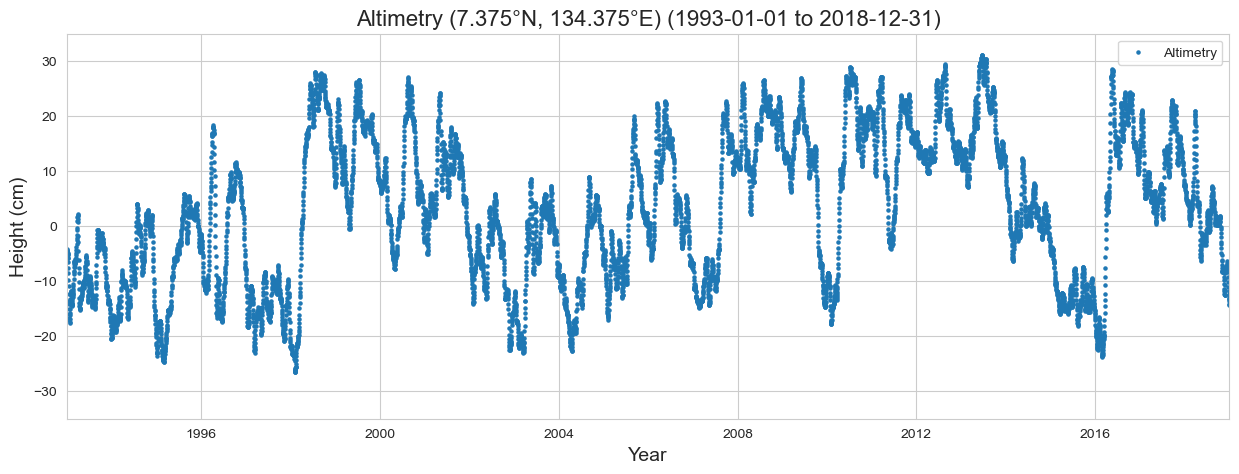

In [12]:
# Set the style of the plot
sns.set_style("whitegrid")

# Set the style of the plot
sns.set_style("whitegrid")

# Create a color palette
palette = sns.color_palette("Paired")

# Create the figure and the axes
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data

# plot altimetry data
ax.scatter(sla_nearest['time'], 100*sla_nearest, label='Altimetry', color=palette[1], alpha=1, s= 5)

# Set the title and labels
ax.set_title(f'Altimetry ({lat_str}, {lon_str}) ({start_date_str} to {end_date_str})', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Height (cm)', fontsize=14)

# Set the y limits
ax.set_ylim([-35, 35])

# Set the x limits
ax.set_xlim([start_date, end_date])

# Add a legend
ax.legend()

### Set the Datum to MHHW

Not sure that MHHW datum is helpful for this??? Unless it is to look at "where is the water today relative to a known datum?" Note that I am using daily averages here, so it seems low. (And that's because it is. MHHW doesn't stay there all day...)
The sea level anomaly is referenced to the [1993, 2012] period; Let's reset this to MHHW of Malakal tide gauge

In [13]:
# get the MHHW from the UH Sea Level Center website
mhhw = 2.162  # in meters, hard-coded for now

# Resetting the sea level anomaly to MHHW of Malakal tide gauge
rsl_daily_mhhw = rsl_daily + epoch_daily_mean - mhhw #add the epoch mean back to the tide gauge data, then subtract MHHW

# now do a similar thing for the altimetry data
sla_mhhw = sla_nearest + epoch_daily_mean-epoch_daily_mean_cmems - mhhw #yikes, this is foul looking

### Calculate change
Calculate the Absolute Sea Level Change (magnitude in cm) within the area/grid of Interest for the Period of Record (1993-2022).

To do this, we'll first define a function that calculates the sea level change magnitude.

In [14]:
def process_trend_with_nan(sea_level_anomaly):
    times = pd.to_datetime(sea_level_anomaly['time'].values)

    sea_level_anomaly_nonan = sea_level_anomaly.dropna(dim='time')

    # Detrend the non-NaN data
    # Ensure that the detrend function is applied along the time axis
    nonan_detrended = detrend(sea_level_anomaly_nonan.squeeze(), axis=0)

    # Create a new DataArray to hold the detrended data with NaNs reinserted
    detrended_with_nans = xr.full_like(sea_level_anomaly, fill_value=np.nan)
    detrended_with_nans.loc[dict(time=sea_level_anomaly_nonan['time'])] = nonan_detrended

    # Calculate trend magnitude
    sea_level_trend = sea_level_anomaly - detrended_with_nans
    trend_mag = sea_level_trend[-1] - sea_level_trend[0]

    time_mag = (times[-1] - times[0]) / np.timedelta64(1, 'Y')

    trend_rate = trend_mag / time_mag

    return trend_mag, sea_level_trend, trend_rate                


We'll run this at our tide gauge location (using the MHHW datum).

In [15]:
# calculate the trend at the tide gauge location
trend_mag_asl, trend_line_asl, trend_rate_asl = process_trend_with_nan(sla_mhhw)


Now we'll run that function for every grid point in our dataset.

In [16]:
trend_mag_cmems, trend_line_cmems, trend_rate_cmems = process_trend_with_nan(sla)

trend_mag_cmems

<xarray.DataArray 'sla' (latitude: 42, longitude: 30)>
array([[0.12487541, 0.12443124, 0.12441588, ..., 0.12057757, 0.12103298,
        0.1216079 ],
       [0.12339494, 0.12317126, 0.12309493, ..., 0.12201859, 0.12265486,
        0.122929  ],
       [0.12234466, 0.12250724, 0.12235102, ..., 0.12329087, 0.12398867,
        0.12393241],
       ...,
       [0.15246544, 0.15107527, 0.14979549, ..., 0.14676899, 0.14614305,
        0.14566854],
       [0.1502352 , 0.1490968 , 0.14814612, ..., 0.14241473, 0.1416442 ,
        0.1410236 ],
       [0.14799386, 0.1470343 , 0.14637114, ..., 0.13882999, 0.13786332,
        0.13725525]])
Coordinates:
  * latitude   (latitude) float32 1.625 1.875 2.125 2.375 ... 11.38 11.62 11.88
  * longitude  (longitude) float32 129.6 129.9 130.1 130.4 ... 136.4 136.6 136.9

Calculate the weighted mean for the region of interest. (Probably not necessary for this application ???)


In [17]:
# calculate the area weights as cosine of latitude (For a rectangular grid, this is equivalent to multiplying by the grid cell area)
weights = np.cos(np.deg2rad(sla.latitude))
weights.name = "weights"

# apply weights to the trend data
trend_mag_weighted = trend_mag_cmems.weighted(weights)

# calculate the regional mean
trend_mag_regional = trend_mag_weighted.mean(dim=('latitude', 'longitude'))

output = 'The regional magnitude of sea level change is {:.2f} cm for the time period bounded by {} and {}.'.format(100*trend_mag_regional.values, start_date_str, end_date_str)
print(output)

The regional magnitude of sea level change is 13.40 cm for the time period bounded by 1993-01-01 and 2018-12-31.


### Plot a map
Plot the Results (in a map that includes the EEZ) – MAP

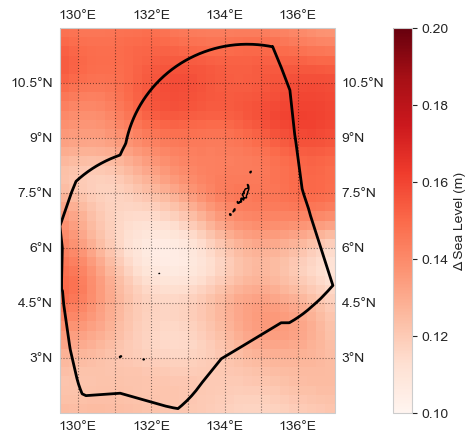

In [18]:

# plot a map of the magnitude of SL change
fig, ax = plt.subplots(figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# set a colormap to be used for both sets of data
palette = sns.color_palette("Reds", as_cmap=True)
cmap = palette
vmax=0.2
vmin=0.1

# plot the trend
trend_mag_cmems.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap, cbar_kwargs={'label': 'Δ Sea Level (m)'})

ax.coastlines()
ax.add_feature(cfeature.LAND, color='lightgrey')
# add the EEZ
ax.plot(palau_eez[:, 0], palau_eez[:, 1], transform=ccrs.PlateCarree(), color='black', linewidth=2)
# show latitude and longitude grid lines
gl = ax.gridlines(draw_labels=True, linestyle=':', color='black', alpha=0.5)


(ASLtimeseries)=
### Plot time series
Now we'll plot a time series that includes a trend line, the Absolute Sea Level Change (magnitude in cm) within area/s in proximity to the Tide Station/s – PLOT


Text(0.02, 0.9, 'Trend: 0.56 cm/year')

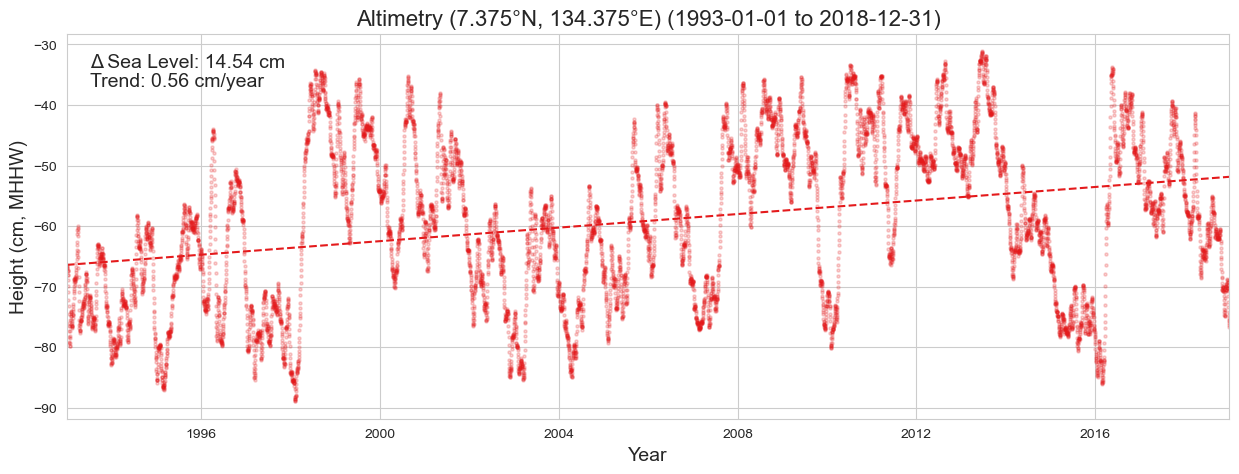

In [19]:
# Set the style of the plot
sns.set_style("whitegrid")

# Create a color palette
palette = sns.color_palette("Set1")

# Plot the timeseries
# Create the figure and the axes
fig, ax = plt.subplots(figsize=(15, 5))
# plot altimetry data
ax.scatter(sla_mhhw['time'], 100*sla_mhhw, label='Altimetry', color=palette[0], alpha=0.2, s= 5)
ax.plot(time_cmems, 100*trend_line_asl, label='Altimetry Trend', color=palette[0], linestyle='--')

# Set the title and labels
ax.set_title(f'Altimetry ({lat_str}, {lon_str}) ({start_date_str} to {end_date_str})', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Height (cm, MHHW)', fontsize=14)

# Set the y limits
#ax.set_ylim([-100, -20])

# Set the x limits
ax.set_xlim([start_date, end_date])


# print on figure the trend magnitude and rate
ax.text(0.02, 0.95, f'Δ Sea Level: {100*trend_mag_asl:.2f} cm', transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
ax.text(0.02, 0.90, f'Trend: {100*trend_rate_asl:.2f} cm/year', transform=ax.transAxes, fontsize=14,    
        verticalalignment='top')

### Calculate rate and magnitude of change
Calculate values for both the Trend (rate of change) and Magnitude of Change

In [20]:
# This was already done.

## Retrieve the Tide Station Data 
### Assess Station Data Quality 
for the POR (1993-2022 …consult w/Ayesha and John)


### Set the Datum to MHHW 
…and plot the hourly time series – PLOT

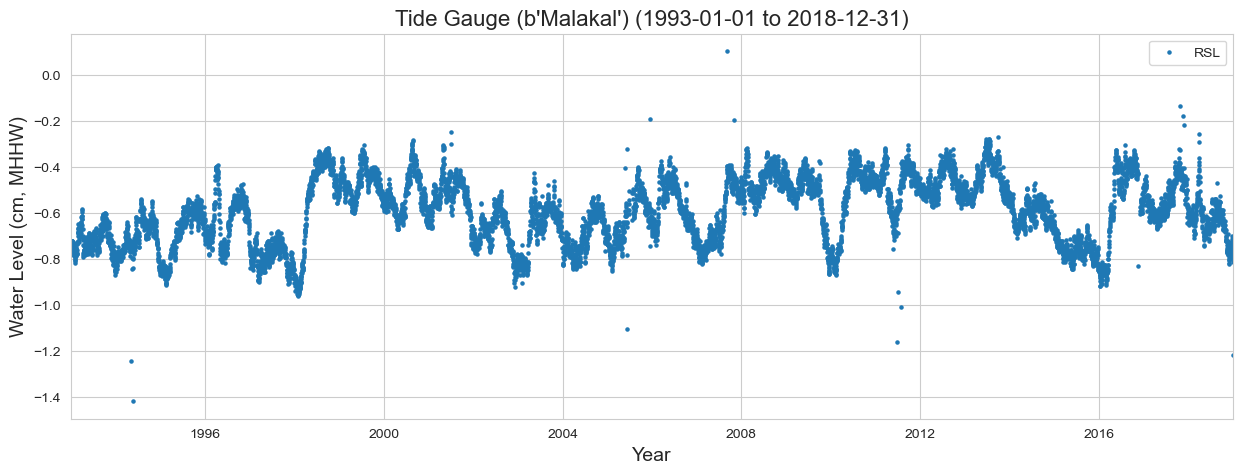

In [21]:
# Set the style of the plot
sns.set_style("whitegrid")

# Set the style of the plot
sns.set_style("whitegrid")

# Create a color palette
palette = sns.color_palette("Paired")

# Create the figure and the axes
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data

# plot altimetry data
ax.scatter(rsl_daily_mhhw['time'],rsl_daily_mhhw, label='RSL', color=palette[1], alpha=1, s= 5)

# Set the title and labels
ax.set_title(f'Tide Gauge ({station_name}) ({start_date_str} to {end_date_str})', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Water Level (cm, MHHW)', fontsize=14)

# Set the y limits
# ax.set_ylim([-35, 35])

# Set the x limits
ax.set_xlim([start_date, end_date])

# Add a legend
ax.legend()

### Plot time series
Plot time series of monthly mean, that includes a trend line, the Relative Sea Level Sea Level Change (magnitude in cm) within area/s in proximity to the Tide Station/s – PLOT
(RSLtimeseries)=

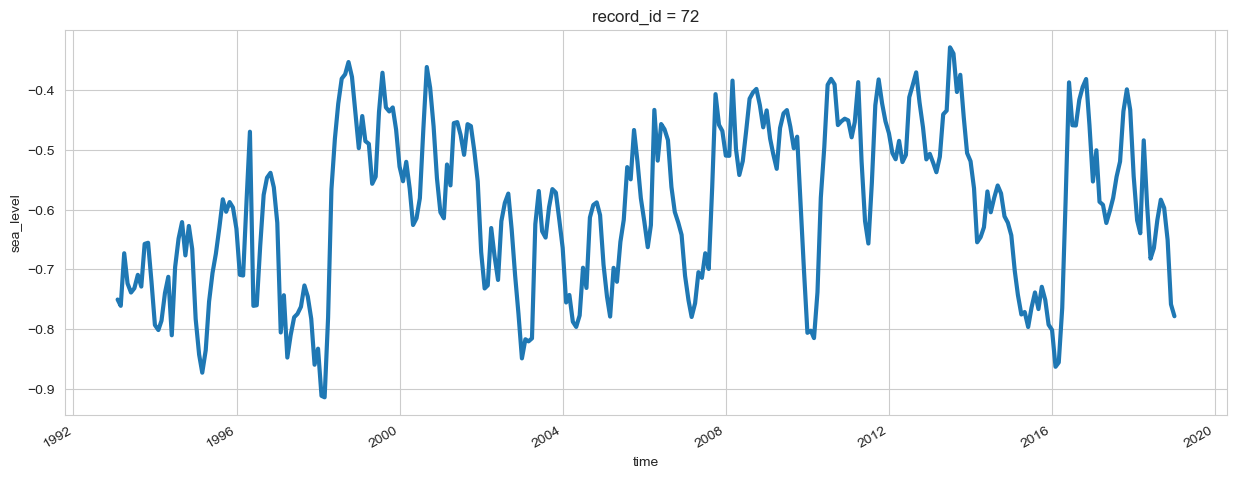

In [22]:
# plot the monthly mean sea level
fig, ax = plt.subplots(figsize=(15, 5))
rsl_daily_mhhw.resample(time='1M').mean().plot(ax=ax, label='Tide Gauge', color=palette[1], alpha=1, linewidth=3)


rsl_daily_mhhw = rsl_daily_mhhw.squeeze()



### Calculate rate and magnitude of change
Calculate values for both the Trend (rate of change) and Magnitude of Change

In [23]:
# calculate the rate of change for the tide gauge
trend_mag_rsl, trend_line_rsl, trend_rate_rsl = process_trend_with_nan(rsl_daily_mhhw)

print(f'The trend magnitude for the tide gauge is {100*trend_mag_rsl:.2f} cm.')
print(f'The trend rate for the tide gauge is {100*trend_rate_rsl:.2f} cm/year.')

The trend magnitude for the tide gauge is 12.55 cm.
The trend rate for the tide gauge is 0.48 cm/year.


## Combining both sources

### Create a Table 
That compares the results of sections {numref}`ASLtimeseries` and {numref}`RSLtimeseries`– TABLE

In [24]:

# Constants
DATA_SOURCE_ALTIMETRY = 'CMEMS SSH L4 0.25 deg (SLA)'
DATA_SOURCE_TIDE_GAUGE = 'UHSLC RQDS'
TIME_PERIOD = f'{start_date_str} to {end_date_str}'

# Calculated values
trend_cmyr_altimetry = 100 * trend_rate_asl.values
trend_cmyr_tide_gauge = 100 * trend_rate_rsl.values
delta_sea_level_altimetry = 100 * trend_mag_asl.values
delta_sea_level_tide_gauge = 100 * trend_mag_rsl.values


# Create DataFrame
SL_magnitude_results = pd.DataFrame({
    'Trend (cm/yr)': [trend_cmyr_altimetry, trend_cmyr_tide_gauge],
    'Δ Sea Level (cm)': [delta_sea_level_altimetry, delta_sea_level_tide_gauge],
    'Latitude': [sla_nearest_lat, rsl['lat'].values[0]],
    'Longitude': [sla_nearest_lon, rsl['lon'].values[0]],
    'Time_Period': [TIME_PERIOD, TIME_PERIOD],
    'Data_Source': [DATA_SOURCE_ALTIMETRY, DATA_SOURCE_TIDE_GAUGE],
}, index=['Altimetry', 'Tide Gauge'])

# Save to CSV
output_file_path = data_dir / 'SL_magnitude_results.csv'

# Use the path for operations, e.g., saving a DataFrame
SL_magnitude_results.to_csv(output_file_path)

SL_magnitude_results

,Trend (cm/yr),Δ Sea Level (cm),Latitude,Longitude,Time_Period,Data_Source
Altimetry,0.559432,14.543223,7.375,134.375,1993-01-01 to 2018-12-31,CMEMS SSH L4 0.25 deg (SLA)
Tide Gauge,0.482921,12.554222,7.33,134.462997,1993-01-01 to 2018-12-31,UHSLC RQDS


### Create a Map 
that includes 1.4 (absolute change) with the addition of an icon/s depicting magnitude of (relative) change at the tide station/s (see UHLSC webpage) – MAP 


Red is a scary color, this is not great.


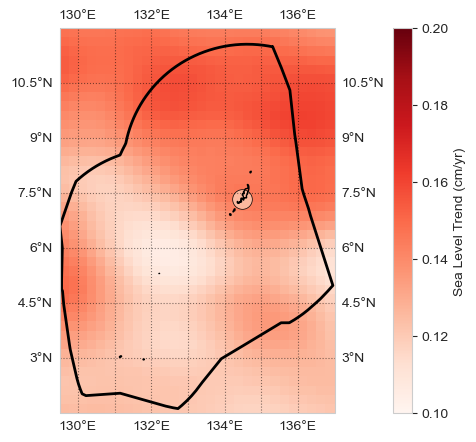

In [25]:
# plot a map of the trend
fig, ax = plt.subplots(figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# set a colormap to be used for both sets of data
palette = sns.color_palette("Reds", as_cmap=True)
cmap = palette
vmax=0.20
vmin=0.1

# plot the trend
trend_mag_cmems_cm = 100*trend_mag_cmems
trend_mag_cmems.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap, cbar_kwargs={'label': 'Sea Level Trend (cm/yr)'})

ax.coastlines()
ax.add_feature(cfeature.LAND, color='lightgrey')
# add the EEZ
ax.plot(palau_eez[:, 0], palau_eez[:, 1], transform=ccrs.PlateCarree(), color='black', linewidth=2)
# show latitude and longitude grid lines
gl = ax.gridlines(draw_labels=True, linestyle=':', color='black', alpha=0.5)
# add the tide gauge location with black outlined dot, colored by the sea level value
ax.scatter(rsl['lon'], rsl['lat'], transform=ccrs.PlateCarree(), s=200, c=trend_mag_rsl, vmin=vmin, vmax=vmax, cmap=cmap,linewidth=0.5, edgecolor='black')


print('Red is a scary color, this is not great.')


 ### Create a Time series plot 
 that include both Absolute (1.5) and Relative Time Series (2.3) – PLOT


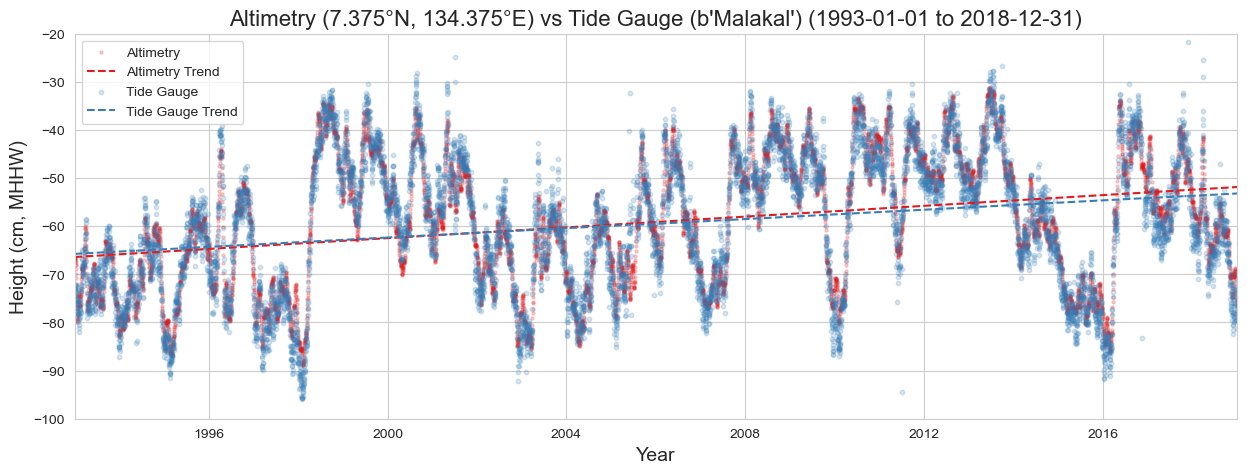

In [26]:
# Set the style of the plot
sns.set_style("whitegrid")

# Create a color palette
palette = sns.color_palette("Set1")

# Plot the timeseries
# Create the figure and the axes
fig, ax = plt.subplots(figsize=(15, 5))
# plot altimetry data
ax.scatter(sla_mhhw['time'], 100*sla_mhhw, label='Altimetry', color=palette[0], alpha=0.2, s= 5)
ax.plot(sla_mhhw['time'], 100*trend_line_asl, label='Altimetry Trend', color=palette[0], linestyle='--')

# plot tide gauge data
ax.scatter(rsl_daily_mhhw['time'], 100*rsl_daily_mhhw, label='Tide Gauge', color=palette[1], alpha=0.2, s= 10)
ax.plot(rsl_daily_mhhw['time'], 100*trend_line_rsl, label='Tide Gauge Trend', color=palette[1], linestyle='--')

# Set the title and labels
ax.set_title(f'Altimetry ({lat_str}, {lon_str}) vs Tide Gauge ({station_name}) ({start_date_str} to {end_date_str})', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Height (cm, MHHW)', fontsize=14)

# Set the y limits
ax.set_ylim([-100, -20])

# Set the x limits
ax.set_xlim([start_date, end_date])

# Add a legend
ax.legend()